In [1]:
'''
Integrantes: Mariana Saavedra, David Herrera
'''
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc
def readCsv(file):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        Cat=dict()
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                for i in range(len(row)):
                    try:
                        float(row[i])
                    except ValueError:
                        try:
                            Cat[i].add(row[i])
                        except:
                            Cat[i]=set([row[i]])
        line_count = 0
        d=[]
        csv_file.seek(0)
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                temp=[]
                for i in range(len(row)):
                    try:
                        temp.append(float(row[i]))
                    except ValueError:
                        temp.append(list(Cat[i]).index(row[i]))
                d.append(temp)
    return  np.array(d)
def PCAf(arr, dim):
    mean = np.average(arr, axis=0)
    cov = np.cov(arr, bias=True, rowvar=False)
    eValue, eVectors = np.linalg.eigh(cov)
    evIndices = np.flip(np.argsort(eValue))  # get indices of descending eigenvalues
    U = np.empty((cov.shape[0], 0))
    for i in range(dim):
        ui = eVectors.T[evIndices[i]]
        U = np.column_stack([U, ui])
    A = np.empty((0, dim))
    for xi in arr.values:
        ai = np.matmul(U.T, xi)
        A = np.row_stack([A, ai])
    return A

def kMeans(D,k,eps,mu=None,max_iterations=500):
    t=0
    if not mu:
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),len(D.min(0))))
    mun=[mu]
    k=len(mu)
    for l in range(max_iterations):
        t+=1
        c=[]
        for m in range(k):
           c.append([])
        for j in range(D.shape[0]):
            min = np.inf
            temp=0
            for i in range(len(mun[t-1])):
                distancia=np.linalg.norm(D[j]-mun[t-1][i])
                if distancia<min:
                    min=distancia
                    temp=i
            c[temp].append(list(D[j]))
        mu=[]
        for i in range(k):
            sum=np.zeros(len(D[0]))
            for j in c[i]:
                sum+=np.array(j)
            if len(c[i])!=0:
                mu.append(list(sum/len(c[i])))
        mun.append(mu)
        
        error=0
        for i in range(len(mun[t])):
            error+=(abs(np.linalg.norm(np.array(mun[-1][i])- np.array(mun[-2][i]))))**2
        if error < eps:
            break
    print("\t\t tomo",l,"iteraciones")
    return c,mu
def multivariate_normal(x, mean, covariance):
    x_m = x - mean
    d=len(x)
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
def  EM(D, k, eps, mu = None, independent = False,max_iterations=500):
    n,p=D.shape
    t=0
    cov=[]
    pis=[]
    if not mu:
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),p))

    covas=[]
    for ki in range(k):
        sum=np.zeros((p, p))
        for j in range(n):
            ys = np.reshape(D[j]- mu[ki], (p,1))
            sum += np.dot(ys, ys.T)
        covas.append(sum)
    for ki in range(k):
        cov.append((covas[ki])/n)#np.identity(p))
        pis.append(1/k)
    mut=[mu]
    for l in range(max_iterations):
        t+=1
        w = np.zeros((k, n))
        #Expectation Step
        for i in range(k):
            for j in range(n):
                w[i, j] = sc.multivariate_normal(mut[t-1][i], cov[i]).pdf(D[j]) *pis[i]
        w = w/w.sum(0)
        #check sum 1
        # print("---",w.sum(0))
            
        #maximization Step
        
        # mu
        mu = np.zeros((k, p))
        for i in range(k):
            for j in range(n):
                mu[i] += w[i, j] * D[j]
            mu[i] /= w[i, :].sum()
        mut.append(mu)
        
        # covariance
        if independent:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.zeros((p, p))
                    np.fill_diagonal(ys, (D[j]- mu[i])**2)
                    cov[i] += w[i,j] * ys
                cov[i] /= w[i,:].sum()
        else:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.reshape(D[j]- mu[i], (p,1))
                    cov[i] += w[i,j] * np.dot(ys, ys.T)
                cov[i] /= w[i,:].sum()
        # pi
        pis = np.zeros(k)
        for j in range(k):
            for i in range(n):
                pis[j] += w[j, i]
        pis /= n
        
        error=0
        for i in range(len(mut[t])):
            error+=(abs(np.linalg.norm(np.array(mut[-1][i])- np.array(mut[-2][i]))))**2
        if error < eps:
            break
    print("\t\t tomo",l,"iteraciones")
    return w, mu, cov

In [96]:
D=readCsv("Mall_Customers.csv")
menor=np.inf
menork=0
print('--------------------------------- K means-----------------------------------')
for k in range(2,5+1):
    print('k=',k)
    for i in range(10):
        print('\t intento',i+1)
        c,mu=kMeans(D,k,0.001)
        curr_sse=0
        for ci in range(len(c)):
            for p in c[ci]:
                curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
        if curr_sse<menor:
            menor=curr_sse
            menork=k
        print('\t\t con diferencia ',curr_sse)
        for mi in range(len(mu)):
            print('\t\t centro',mi+1,'=',mu[mi],'con puntos',c[mi])
    print('\n\tsse=',menor)
    print('\n\n')
print('el mejor k es',menork)

--------------------------------- K means-----------------------------------
k= 2
	 intento 1
		 tomo 3 iteraciones
		 con diferencia  8314.700686011081
		 centro 1 = [50.0, 0.5959595959595959, 39.94949494949495, 39.343434343434346, 49.93939393939394] con puntos [[1.0, 0.0, 19.0, 15.0, 39.0], [2.0, 0.0, 21.0, 15.0, 81.0], [3.0, 1.0, 20.0, 16.0, 6.0], [4.0, 1.0, 23.0, 16.0, 77.0], [5.0, 1.0, 31.0, 17.0, 40.0], [6.0, 1.0, 22.0, 17.0, 76.0], [7.0, 1.0, 35.0, 18.0, 6.0], [8.0, 1.0, 23.0, 18.0, 94.0], [9.0, 0.0, 64.0, 19.0, 3.0], [10.0, 1.0, 30.0, 19.0, 72.0], [11.0, 0.0, 67.0, 19.0, 14.0], [12.0, 1.0, 35.0, 19.0, 99.0], [13.0, 1.0, 58.0, 20.0, 15.0], [14.0, 1.0, 24.0, 20.0, 77.0], [15.0, 0.0, 37.0, 20.0, 13.0], [16.0, 0.0, 22.0, 20.0, 79.0], [17.0, 1.0, 35.0, 21.0, 35.0], [18.0, 0.0, 20.0, 21.0, 66.0], [19.0, 0.0, 52.0, 23.0, 29.0], [20.0, 1.0, 35.0, 23.0, 98.0], [21.0, 0.0, 35.0, 24.0, 35.0], [22.0, 0.0, 25.0, 24.0, 73.0], [23.0, 1.0, 46.0, 25.0, 5.0], [24.0, 0.0, 31.0, 25.0, 73.0], [25.0

		 tomo 7 iteraciones


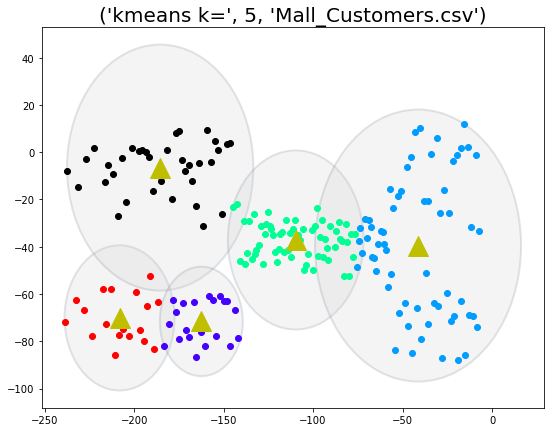

In [97]:
colors =['#ff0000','#000000','#00ff95','#009dff','#4400ff','#736c73']
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], color=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.2, zorder=1))
tittulo='kmeans k=',k, "Mall_Customers.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

In [98]:
print('--------------------------------- Em dependiente-----------------------------------')
for k in range(2,5+1):
    print('k=',k)
    for i in range(10):
        print('\t intento',i+1)
        try:
            w, mu, cov=EM(D,k,0.001)
            for mi in range(len(mu)):
                print('\t\t centro',mi+1,'=',mu[mi])
        except:
            ''
    print('\n\n')

--------------------------------- Em dependiente-----------------------------------
k= 2
	 intento 1
		 tomo 12 iteraciones
		 centro 1 = [89.12720469  0.52145909 39.49464276 54.82568351 48.59621318]
		 centro 2 = [181.91619853   0.8359088   34.23509559 101.6111433   61.68127815]
	 intento 2
		 tomo 28 iteraciones
		 centro 1 = [181.88485593   0.83628907  34.23802714 101.58465072  61.69191818]
		 centro 2 = [89.11736115  0.52135769 39.49503919 54.82221528 48.59271873]
	 intento 3
		 tomo 17 iteraciones
		 centro 1 = [88.04079496  0.52899236 39.62460163 54.3338617  48.23000273]
		 centro 2 = [182.35359655   0.76371178  33.76107745 101.46403928  63.14234756]
	 intento 4
		 tomo 53 iteraciones
		 centro 1 = [87.90273334  0.52996937 39.64241657 54.27745717 48.18218511]
		 centro 2 = [182.33390787   0.75508388  33.70233214 101.37242737  63.3080561 ]
	 intento 5
		 tomo 18 iteraciones
		 centro 1 = [182.33427022   0.75541681  33.70460149 101.37557538  63.30265087]
		 centro 2 = [87.90759848 

In [100]:
print('--------------------------------- Em independiente-----------------------------------')
for k in range(2,5+1):
    print('k=',k)
    for i in range(10):
        print('\t intento',i+1)
        try:
            w, mu, cov=EM(D,k,0.001,independent=True)
            for mi in range(len(mu)):
                print('\t\t centro',mi+1,'=',mu[mi])
        except:
            ''
    print('\n\n')

--------------------------------- Em independiente-----------------------------------
k= 2
	 intento 1
		 tomo 14 iteraciones
		 centro 1 = [159.99726623   0.52078968  36.46550848  85.84162811  50.93807998]
		 centro 2 = [60.6198313   0.58628212 40.44829065 43.61408538 49.70527552]
	 intento 2
		 tomo 22 iteraciones
		 centro 1 = [159.93227385   0.52102997  36.46567704  85.8114433   50.93212481]
		 centro 2 = [60.55888221  0.58618959 40.45237053 43.58991277 49.70797973]
	 intento 3
		 tomo 21 iteraciones
		 centro 1 = [60.5659431   0.5862004  40.45189384 43.59271346 49.70766876]
		 centro 2 = [159.93981724   0.52100204  36.46566231  85.81494501  50.93281007]
	 intento 4
		 tomo 16 iteraciones
		 centro 1 = [60.56596741  0.58620044 40.4518922  43.5927231  49.70766769]
		 centro 2 = [159.93984321   0.52100194  36.46566225  85.81495706  50.93281243]
	 intento 5
		 tomo 20 iteraciones
		 centro 1 = [60.56114382  0.58619305 40.45221773 43.59080984 49.70788019]
		 centro 2 = [159.9346904    

--------------------------------- K means riddle-----------------------------------
k= 2
		 tomo 2 iteraciones
		 centro 1 = [0.5092572284097497, 0.5336695465042639, 0.49734440108088135, 0.5343991937898876, 0.5054878186013758, 0.50210015220254, 0.47109359760264663, 0.5021778526978335, 0.5154566350869633, 0.5055876288408153, 0.5356464387662385, 0.4890685392905181, 0.511024306877841, 0.5065350539746583, 0.5080135603018568, 0.5106527490788252, 0.46839075314507717, 0.5138717089990797, 0.5151923396524954, 0.49454426727500655, 0.5118795144492335, 0.5020535577682741, 0.4766963716640988, 0.4910727649880846, 0.48759696240972206, 0.4999621624006909, 0.48794564628493287, 0.5071175863837668, 0.502150857370245, 0.5090126200431554, 0.475607361072886, 0.4992620392512597, 0.5067870121840432, 0.49180613835443887, 0.48957249908780653, 0.4947653091974442, 0.503177914362423, 0.4881351793536488, 0.5057216497189102, 0.5217924785684299, 0.5134508081206518, 0.4902107721890708, 1.4674922474456285, 0.5123303732

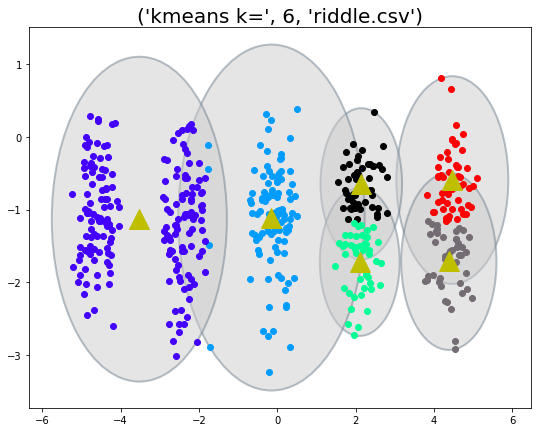

In [101]:
D=readCsv("riddle.csv")
print('--------------------------------- K means riddle-----------------------------------')
menor=np.inf
menork=0
for k in range(2,6+1):
    print('k=',k)
    c,mu=kMeans(D,k,0.001)
    curr_sse=0
    for ci in range(len(c)):
        for p in c[ci]:
            curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
    if curr_sse<menor:
        menor=curr_sse
        menork=k
    for mi in range(len(mu)):
        print('\t\t centro',mi+1,'=',mu[mi])
print('el mejor k es',menork)
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], c=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.5, zorder=1))
tittulo='kmeans k=',k, "riddle.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

In [ ]:
c,mu=kMeans(PCAf(pd.DataFrame(D), 3),k,0.01)
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')
for i in range(len(c)):
    for j in range(len(c[i])):
        ax.plot([c[i][j][0]],[c[i][j][1]],[c[i][j][2]], c=colors[i],marker='o')
for i in range(len(c)):
    ax.plot([mu[i][0]],[mu[i][1]],[mu[i][2]], 'y^',markersize=20)
ax.view_init(30, 45)
ax.set_title(tittulo,fontsize=10)
plt.show()

--------------------------------- K means delayed flights-----------------------------------
k= 2
		 tomo 5 iteraciones
		 centro 1 = [2008.0, 1.0, 10.355465352276022, 4.509712960278342, 1664.0321832415193, 1589.3287909538997, 1685.0321832415193, 1704.9913018266163, 0.0, 2824.5908959118583, 256.76138011017684, 107.7265874166425, 108.90113076253986, 90.22586256886053, 46.18179182371702, 47.35633516961438, 32.13801101768629, 31.295447955929255, 611.276891852711, 5.123224122934184, 12.377500724847781, 0.0, 0.0, 0.0, 11.176862858799652, 1.628008118295158, 5.107857349956509, 0.1400405914757901, 28.12902290518991]
		 centro 2 = [2008.0, 1.0, 9.940009158907037, 4.492443901694398, 1620.8641428789497, 1547.5667836971454, 1680.6951610441154, 1698.1865364066555, 0.0, 768.366661578385, 246.96092199664173, 105.20729659593955, 106.03114028392612, 87.74355060296138, 45.76003663562815, 46.583880323614714, 31.79789345138147, 31.534116928713175, 592.9155854068081, 5.169897725538085, 12.293848267440085, 

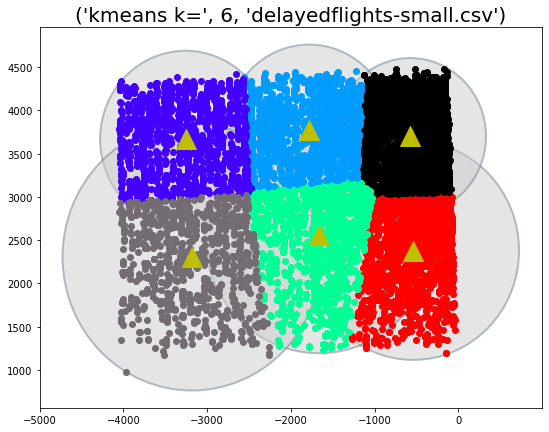

In [102]:
D=readCsv("delayedflights-small.csv")
print('--------------------------------- K means delayed flights-----------------------------------')
menor=np.inf
menork=0
for k in range(2,6+1):
    print('k=',k)
    c,mu=kMeans(D,k,0.001)
    curr_sse=0
    for ci in range(len(c)):
        for p in c[ci]:
            curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
    if curr_sse<menor:
        menor=curr_sse
        menork=k
    for mi in range(len(mu)):
        print('\t\t centro',mi+1,'=',mu[mi])
print('el mejor k es',menork)
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], c=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.5, zorder=1))
tittulo='kmeans k=',k, "delayedflights-small.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

		 tomo 31 iteraciones


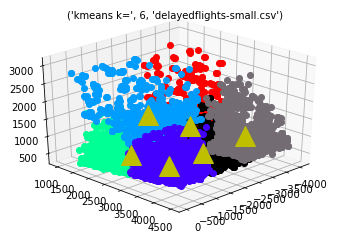

In [103]:
c,mu=kMeans(PCAf(pd.DataFrame(D), 3),k,0.01)
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')
for i in range(len(c)):
    for j in range(len(c[i])):
        ax.plot([c[i][j][0]],[c[i][j][1]],[c[i][j][2]], c=colors[i],marker='o')
for i in range(len(c)):
    ax.plot([mu[i][0]],[mu[i][1]],[mu[i][2]], 'y^',markersize=20)
ax.view_init(30, 45)
ax.set_title(tittulo,fontsize=10)
plt.show()

		 tomo 8 iteraciones
[[41.0, 0.0, 65.0, 38.0, 35.0], [43.0, 1.0, 48.0, 39.0, 36.0], [45.0, 0.0, 49.0, 39.0, 28.0], [47.0, 0.0, 50.0, 40.0, 55.0], [48.0, 0.0, 27.0, 40.0, 47.0], [49.0, 0.0, 29.0, 40.0, 42.0], [50.0, 0.0, 31.0, 40.0, 42.0], [51.0, 0.0, 49.0, 42.0, 52.0], [52.0, 1.0, 33.0, 42.0, 60.0], [53.0, 0.0, 31.0, 43.0, 54.0], [54.0, 1.0, 59.0, 43.0, 60.0], [55.0, 0.0, 50.0, 43.0, 45.0], [56.0, 1.0, 47.0, 43.0, 41.0], [57.0, 0.0, 51.0, 44.0, 50.0], [58.0, 1.0, 69.0, 44.0, 46.0], [59.0, 0.0, 27.0, 46.0, 51.0], [60.0, 1.0, 53.0, 46.0, 46.0], [61.0, 1.0, 70.0, 46.0, 56.0], [62.0, 1.0, 19.0, 46.0, 55.0], [63.0, 0.0, 67.0, 47.0, 52.0], [64.0, 0.0, 54.0, 47.0, 59.0], [65.0, 1.0, 63.0, 48.0, 51.0], [66.0, 1.0, 18.0, 48.0, 59.0], [67.0, 0.0, 43.0, 48.0, 50.0], [68.0, 0.0, 68.0, 48.0, 48.0], [69.0, 1.0, 19.0, 48.0, 59.0], [70.0, 0.0, 32.0, 48.0, 47.0], [71.0, 1.0, 70.0, 49.0, 55.0], [72.0, 0.0, 47.0, 49.0, 42.0], [73.0, 0.0, 60.0, 50.0, 49.0], [74.0, 0.0, 60.0, 50.0, 56.0], [75.0, 1.0, 59.0

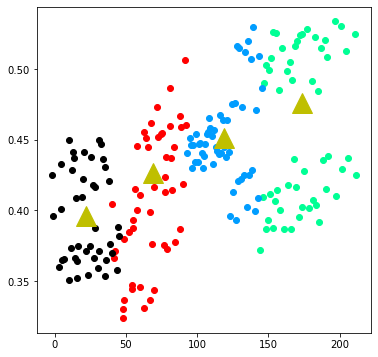

In [10]:
'''
Primero realizar k-means con los datos originales y luego proyectarlos con PCA
La proyeccion hace que los clusters se pierdan y no me parece una buena representacion
asi que por eso en los puntos superiores primero lo proyecto y luego aplico el algoritmo 
'''
from sklearn.decomposition import IncrementalPCA
colors =['#ff0000','#000000','#00ff95','#009dff','#4400ff','#736c73']
D=readCsv("Mall_Customers.csv")
c,mu=kMeans(D,5,0.001)
puntos=[]
n_batches = 2
inc_pca = IncrementalPCA(n_components=2)
print(c[0])
for i in range(len(mu)):
    for X_batch in np.array_split(c[i],n_batches ):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(c[i])
    X_ipca_reconst = inc_pca.inverse_transform(X_ipca)
    puntos.append(X_ipca_reconst)
    
for X_batch in np.array_split(mu,n_batches ):
    inc_pca.partial_fit(X_batch)
X_ipca = inc_pca.transform(mu)
X_ipca_reconst = inc_pca.inverse_transform(X_ipca)    
medias=X_ipca_reconst
fig2d,ax=plt.subplots(figsize=(6,6))
for i in range(len(puntos)):
    for j in range(len(puntos[i])):
        plt.plot([puntos[i][j][0]],[puntos[i][j][1]],color=colors[i],marker='o')
for i in range(len(medias)):
    plt.plot([medias[i][0]],[medias[i][1]], color='y',marker='^',markersize=20)